# Модель прогнозирования стоимости жилья для агентства недвижимости

задача — разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок

In [642]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Анализ и обработка данных

In [643]:
# загрузка данных в датафрейм
data = pd.read_csv("./data/data.csv")
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


### Очистка данных

In [644]:
# определяем наличие дубликатов
data_duplicated = data.duplicated()
data_duplicated.sum()

50

In [645]:
# удаляем дубликаты
data = data.drop_duplicates(ignore_index=True)
data.shape[0]

377135

In [646]:
# смотрим пропуски
data.isna().sum()

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
homeFacts            0
fireplace       274024
city                34
schools              0
sqft             40550
zipcode              0
beds             91254
state                0
stories         150674
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

Записи, в которых отсутствует информация о целевой переменной (target) удаляем, для обучения модели они нам не потребуются

In [647]:
# удаляем строки с пустым target
data = data.dropna(axis=0, subset=['target'])
data.shape

(334560, 18)

### Разворачиваем поле 'homeFacts'

In [648]:
data['Year built'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][0]['factValue'])
data['Remodeled year'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][1]['factValue'])
data['Heating'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][2]['factValue'])
data['Cooling'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][3]['factValue'])
data['Parking'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][4]['factValue'])
data['lotsize'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][5]['factValue'])
data['Price/sqft'] = data['homeFacts'].apply(lambda x: eval(x)['atAGlanceFacts'][6]['factValue'])

# удалим исходное поле
data = data.drop(labels=['homeFacts'], axis=1)

In [650]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334560 entries, 0 to 377134
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   status          298385 non-null  object
 1   private pool    4151 non-null    object
 2   propertyType    317882 non-null  object
 3   street          334559 non-null  object
 4   baths           265933 non-null  object
 5   homeFacts       334560 non-null  object
 6   fireplace       101254 non-null  object
 7   city            334526 non-null  object
 8   schools         334560 non-null  object
 9   sqft            334560 non-null  object
 10  zipcode         334560 non-null  object
 11  beds            275131 non-null  object
 12  state           334560 non-null  object
 13  stories         223315 non-null  object
 14  mls-id          24414 non-null   object
 15  PrivatePool     39789 non-null   object
 16  MlsId           272067 non-null  object
 17  target          334560 non-null  o

In [662]:
data['Year built'].value_counts().sort_index()

Year built
                28366
1                   2
1019                1
1057                1
1060                1
                ...  
2021               55
2022                8
2025                2
559990649990        2
No Data          1084
Name: count, Length: 228, dtype: int64

### scools

In [656]:
eval(data['schools'][0])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'],
  'data': {'Distance': ['2.7 mi',
    '3.6 mi',
    '5.1 mi',
    '4.0 mi',
    '10.5 mi',
    '12.6 mi',
    '2.7 mi',
    '3.1 mi'],
   'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']},
  'name': ['Southern Pines Elementary School',
   'Southern Middle School',
   'Pinecrest High School',
   'Southern Pines Primary School',
   "Crain's Creek Middle School",
   'Union Pines High School',
   'Episcopal Day Private School',
   'Calvary Christian Private School']}]

### Преобразование типа целевой переменной и очистка выбросов по целевой переменной

In [357]:
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
specs_list = ['$',',',' ','+']

def search_for_specs(arg):
    if '/mo' in arg: # похоже на стоимость помесячной аренды, помечаем эти записи nan для последующего удаления
        arg = np.nan
        return arg
    for symbol in arg:
        if symbol in specs_list:
            arg = arg.replace(symbol,'')
    return arg
# преобразуем в тип float
data['target'] = data['target'].apply(search_for_specs).astype('float')

# удаляем новые строки с пустым target
data = data.dropna(axis=0, subset=['target'])
data.shape

(334173, 18)

In [358]:
# Удаляем строки со слишком низкой стоимостью (<1000)
data = data.drop(labels=data[data['target']<10].index, axis=0)
data.shape

(334160, 18)

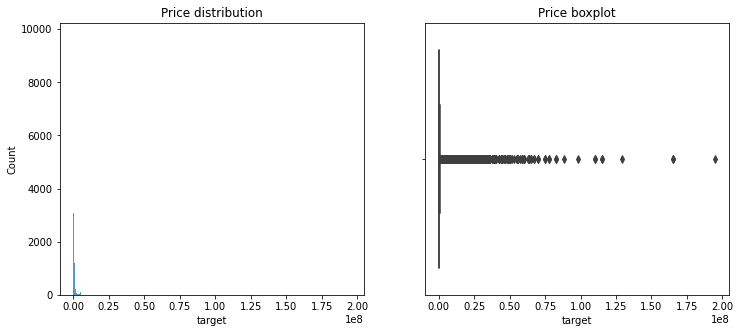

In [359]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = data, x = 'target', ax=axes[0])
histplot.set_title('Price distribution')
boxplot = sns.boxplot( data = data, x = 'target', ax = axes[1])
boxplot.set_title('Price boxplot');

Необходима очистка выбросов методом Тьюки

In [360]:
# Удаляем выбросы методом Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(data, 'target')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 32976
Результирующее число записей: 301184


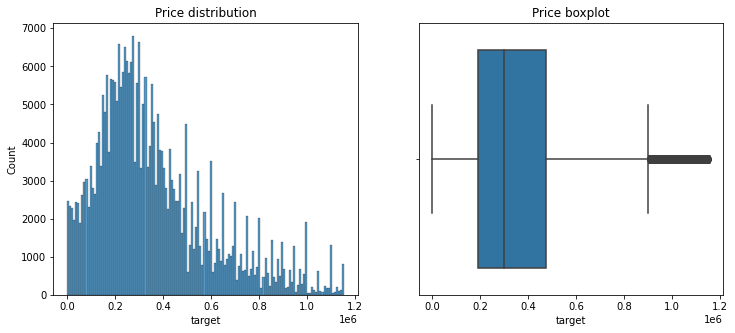

In [361]:
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = cleaned, x = 'target', ax=axes[0])
histplot.set_title('Price distribution')
boxplot = sns.boxplot( data = cleaned, x = 'target', ax = axes[1])
boxplot.set_title('Price boxplot');

### Один из основных признаков для расчета стоимости жилья - площадь. Выполним преобразование типа этого признака и очистку выбросов

In [362]:
data = cleaned
data['sqft']

0               2900
1         1,947 sqft
5           897 sqft
6              1,507
8               3588
             ...    
377128         1,841
377129         1,417
377131    2,000 sqft
377132    1,152 sqft
377134         1,462
Name: sqft, Length: 301184, dtype: object

In [363]:
# убираем спецсимволы
symbols_list = ['sqft','toalinerior','total','interior','livable','area',':','--',' ',',']

def search_for_symbols(arg):
    for sub_string in symbols_list:
        if sub_string in arg:
            arg = str.lower(arg).replace(sub_string,'')
    if arg == '':
        return 0
    return arg
# преобразуем в тип float
data['sqft'] = data['sqft'].apply(search_for_symbols).astype('float')

In [364]:
# Удаляем строки со слишком низкой площадью (<10)
data = data.drop(labels=data[data['sqft']<10].index, axis=0)
data.shape

(289107, 18)

In [365]:
data['sqft'].sort_values()

152217           10.0
373407           10.0
180569           11.0
233929           12.0
56762            17.0
             ...     
187378      4356000.0
142138      5728968.0
74211       7078574.0
376479    456602479.0
62732     795979430.0
Name: sqft, Length: 289107, dtype: float64

In [366]:
# проверяем распределение данных по целевой переменной
#fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
#histplot = sns.histplot(data = cleaned, x = 'sqft', ax=axes[0])
#histplot.set_title('Full square distribution')
#boxplot = sns.boxplot( data = cleaned, x = 'sqft', ax = axes[1])
#boxplot.set_title('Full square boxplot');

In [367]:
outliers, cleaned = outliers_iqr(data, 'sqft')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 9627
Результирующее число записей: 279475


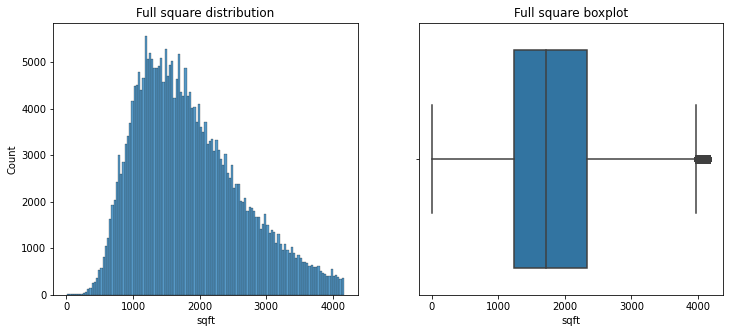

In [368]:
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = cleaned, x = 'sqft', ax=axes[0])
histplot.set_title('Full square distribution')
boxplot = sns.boxplot( data = cleaned, x = 'sqft', ax = axes[1])
boxplot.set_title('Full square boxplot');

In [369]:
data = cleaned
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 279475 entries, 0 to 377134
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        247629 non-null  object 
 1   private pool  3334 non-null    object 
 2   propertyType  264865 non-null  object 
 3   street        279475 non-null  object 
 4   baths         225475 non-null  object 
 5   homeFacts     279475 non-null  object 
 6   fireplace     81828 non-null   object 
 7   city          279475 non-null  object 
 8   schools       279475 non-null  object 
 9   sqft          279475 non-null  float64
 10  zipcode       279475 non-null  object 
 11  beds          237725 non-null  object 
 12  state         279475 non-null  object 
 13  stories       195154 non-null  object 
 14  mls-id        21505 non-null   object 
 15  PrivatePool   29229 non-null   object 
 16  MlsId         223581 non-null  object 
 17  target        279475 non-null  float64
dtypes: float6

In [370]:
data

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.0,28387,4,NC,NaN,NaN,NaN,611019,418000.0
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.0,99216,3 Beds,WA,2.0,NaN,NaN,201916904,310000.0
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897.0,19145,2 Beds,PA,2.0,NaN,NaN,PAPH847006,209000.0
6,Active,NaN,Florida,552 Casanova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...",1507.0,34759,NaN,FL,One,NaN,NaN,S5026943,181500.0
8,Active,NaN,Single Family Home,11182 Owl Ave,2,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588.0,50401,3,IA,NaN,NaN,NaN,190988,244900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377128,NaN,NaN,Single Family,Buildable plan: The Torino (384L) Riverstone R...,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['7/10', '6/10', '5/10'], 'data': ...",1841.0,77089,4,TX,1.0,NaN,NaN,NaN,252990.0
377129,For sale,NaN,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...",1417.0,20001,2,DC,3.0,NaN,NaN,DCDC444306,799000.0
377131,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...",2000.0,60657,3 Beds,IL,9.0,NaN,NaN,10374233,674999.0
377132,for sale,NaN,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...",1152.0,11434,3 Beds,NY,2,NaN,NaN,NaN,528000.0


Кодируем поле статус

In [371]:
data['status'].value_counts()

status
for sale                 116969
Active                    68751
For sale                  36221
foreclosure                5315
New construction           4611
                          ...  
Pending Take Backups          1
Coming soon: Nov 26.          1
Conting Accpt Backups         1
Lease/Purchase                1
Coming soon: Dec 23.          1
Name: count, Length: 146, dtype: int64

### Кодируем поле наличия бассейна

In [372]:
data['PrivatePool'].value_counts()

PrivatePool
yes    21297
Yes     7932
Name: count, dtype: int64

In [373]:
data['private pool'].value_counts()

private pool
Yes    3334
Name: count, dtype: int64

In [374]:
def pool_detect(arg1, arg2):
    #print(type(arg))
    if type(arg1) == str:
        if str.upper(arg1) == 'YES':
            return 1
    elif type(arg2) == str:
        if str.upper(arg2) == 'YES':
            return 1
    else:
        return 0

In [375]:
data['pool'] = data[['private pool','PrivatePool']].apply(lambda x: pool_detect(*x), axis=1)

In [376]:
data['pool'].value_counts()

pool
0    246912
1     32563
Name: count, dtype: int64

In [377]:
# удалим исходные поля
data = data.drop(labels=['private pool','PrivatePool'], axis=1)

### Кодируем статус

In [379]:
# изучаем значения поля статус и определяем основные признаки для кодирования
data['status'].value_counts().head(25)

status
for sale                             116969
Active                                68751
For sale                              36221
foreclosure                            5315
New construction                       4611
Pending                                3927
Pre-foreclosure                        1549
P                                      1292
Under Contract Show                     996
Pre-foreclosure / auction               958
 / auction                              737
Under Contract   Showing                692
Under Contract                          609
Active Under Contract                   546
Contingent                              498
New                                     447
Price Change                            418
A Active                                367
Auction                                 361
Foreclosure                             289
Foreclosed                              250
Under Contract Backups                  245
Contingent Finance And In

Признаки пересекаются, необходимо применить ручное кодирование

In [380]:
data['status'].isna().sum()

31846

In [381]:
# заполняем пропуски заглушкой
data['status'] = data['status'].fillna('unknown')

In [382]:
# кодируем вручную статусы
data['status_1'] = data['status'].apply(lambda x: 1 if 'for sale' in str.lower(x) else 0)
data['status_2'] = data['status'].apply(lambda x: 1 if 'active' in str.lower(x) else 0)
data['status_3'] = data['status'].apply(lambda x: 1 if 'foreclos' in str.lower(x) else 0)
data['status_4'] = data['status'].apply(lambda x: 1 if 'new' in str.lower(x) else 0)
data['status_5'] = data['status'].apply(lambda x: 1 if 'pending' in str.lower(x) or x == 'P' else 0)
data['status_6'] = data['status'].apply(lambda x: 1 if 'pre-foreclosure' in str.lower(x) else 0)
data['status_7'] = data['status'].apply(lambda x: 1 if 'contract' in str.lower(x) else 0)
data['status_8'] = data['status'].apply(lambda x: 1 if 'contingent' in str.lower(x) else 0)

In [383]:
data['status_8'].value_counts()

status_8
0    278569
1       906
Name: count, dtype: int64

In [384]:
# удаляем исходное поле
data = data.drop(labels=['status'], axis=1)

### Кодируем тип недвижимости "propertyType"

In [385]:
# исследуем структуру данных поля
data['propertyType'].value_counts().head(25)

propertyType
single-family home               79218
Single Family                    52404
Single Family Home               28002
condo                            21376
Condo                            14149
townhouse                        10595
Condo/Townhome/Row Home/Co-Op     7141
Townhouse                         6367
Traditional                       5272
multi-family                      4919
lot/land                          2928
Multi Family                      1933
coop                              1706
Ranch                             1703
mobile/manufactured               1506
Single Detached, Traditional      1437
Contemporary                      1342
High Rise                         1318
Detached, One Story               1309
1 Story                           1218
Mobile / Manufactured              944
Colonial                           919
Contemporary/Modern                910
Multi-Family Home                  883
2 Stories                          866
Name: count,

Здесь также лучше подойдет ручное кодирование

In [386]:
# заполняем пропуски заглушкой
data['propertyType'] = data['propertyType'].fillna('unknown')

In [387]:
# кодируем вручную статусы
data['Type_1'] = data['propertyType'].apply(lambda x: 1 if 'single' in str.lower(x) and 'family' in str.lower(x) else 0)
data['Type_2'] = data['propertyType'].apply(lambda x: 1 if 'condo' in str.lower(x) else 0)
data['Type_3'] = data['propertyType'].apply(lambda x: 1 if 'town' in str.lower(x) else 0)
data['Type_4'] = data['propertyType'].apply(lambda x: 1 if 'tradition' in str.lower(x) else 0)
data['Type_5'] = data['propertyType'].apply(lambda x: 1 if 'multi' in str.lower(x) else 0)
data['Type_6'] = data['propertyType'].apply(lambda x: 1 if 'coop' in str.lower(x) else 0)
data['Type_7'] = data['propertyType'].apply(lambda x: 1 if 'ranch' in str.lower(x) else 0)
data['Type_8'] = data['propertyType'].apply(lambda x: 1 if 'mobile' in str.lower(x) else 0)
data['Type_9'] = data['propertyType'].apply(lambda x: 1 if 'contemp' in str.lower(x) else 0)
data['Type_10'] = data['propertyType'].apply(lambda x: 1 if 'high' in str.lower(x) else 0)
data['Type_11'] = data['propertyType'].apply(lambda x: 1 if 'colonial' in str.lower(x) else 0)
data['Type_12'] = data['propertyType'].apply(lambda x: 1 if 'detached' in str.lower(x) else 0)
data['Type_lot'] = data['propertyType'].apply(lambda x: 1 if 'lot' in str.lower(x) or 'land' in str.lower(x) else 0)

In [388]:
# удаляем исходное поле
data = data.drop(labels=['propertyType'], axis=1)

In [389]:
# Удаляем строки с типом "земельный участок"
data = data.drop(labels=data[data['Type_lot']==1].index, axis=0)
data.shape

(276470, 36)

In [390]:
# удаляем исходное поле "земельный участок"
data = data.drop(labels=['Type_lot'], axis=1)

In [391]:
data['Type_1'].value_counts()

Type_1
1    159771
0    116699
Name: count, dtype: int64

In [392]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276470 entries, 0 to 377134
Data columns (total 35 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   street     276470 non-null  object 
 1   baths      224999 non-null  object 
 2   homeFacts  276470 non-null  object 
 3   fireplace  81170 non-null   object 
 4   city       276470 non-null  object 
 5   schools    276470 non-null  object 
 6   sqft       276470 non-null  float64
 7   zipcode    276470 non-null  object 
 8   beds       235801 non-null  object 
 9   state      276470 non-null  object 
 10  stories    193825 non-null  object 
 11  mls-id     21505 non-null   object 
 12  MlsId      220578 non-null  object 
 13  target     276470 non-null  float64
 14  pool       276470 non-null  int64  
 15  status_1   276470 non-null  int64  
 16  status_2   276470 non-null  int64  
 17  status_3   276470 non-null  int64  
 18  status_4   276470 non-null  int64  
 19  status_5   276470 non-null  

### Кодируем количество комнат

In [393]:
data['beds']

0              4
1         3 Beds
5         2 Beds
6            NaN
8              3
           ...  
377128         4
377129         2
377131    3 Beds
377132    3 Beds
377134         3
Name: beds, Length: 276470, dtype: object

In [394]:
data['beds'].isna().sum()

40669

In [395]:
# заполняем пропуски заглушкой. Считаем, что одна комната, если не указано.
data['beds'] = data['beds'].fillna('1')

In [396]:
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
words_list = ['beds',' ','bd','--']

def search_for_symbols(arg):
    for sub_string in words_list:
        if sub_string in str.lower(arg):
            arg = str.lower(arg).replace(sub_string,'')
    if 'sqft' in str.lower(arg) or 'bath' in str.lower(arg) or 'price' in str.lower(arg):
        return 1
    if arg == '':
        return 1
    return arg

# удаляем символы и преобразуем в тип float
data['beds'] = data['beds'].apply(search_for_symbols).astype('float').astype('int')

### Кодируем количество ванных комнат

In [397]:
data['baths']

0             3.5
1         3 Baths
5             NaN
6             NaN
8               2
           ...   
377128          2
377129          3
377131    3 Baths
377132    3 Baths
377134        2.0
Name: baths, Length: 276470, dtype: object

In [398]:
# заполняем пропуски заглушкой
data['baths'] = data['baths'].fillna('0')

In [399]:
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
words_list = ['baths',' ','bathrooms:','ba','~','+','/','sq.ft.','-','semimod','—']

def search_for_symbols(arg):
    for sub_string in words_list:
        if sub_string in str.lower(arg):
            arg = str.lower(arg).replace(sub_string,'')
    if ',' in str.lower(arg):
        arg = str.lower(arg).replace(',','.')
    if arg == '':
        return 1
    return arg

# удаляем символы и преобразуем в тип float
data['baths'] = data['baths'].apply(search_for_symbols).astype('float').astype('int')

In [400]:
data['baths'].sort_values()

90973         0
94210         0
94209         0
94204         0
276060        0
          ...  
174295      750
204990      750
35670       750
324841      750
24724     10101
Name: baths, Length: 276470, dtype: int32

In [401]:
data[data['baths'] == 8].head(5)

,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,...,Type_3,Type_4,Type_5,Type_6,Type_7,Type_8,Type_9,Type_10,Type_11,Type_12
15524,418 Leopard Claw,8,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",Not Applicable,San Antonio,"[{'rating': ['6/10', '5/10', '4/10'], 'data': ...",3041.0,78251,5,TX,...,0,0,0,0,0,0,0,0,0,0
17965,192 Ontario St,8,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Albany,"[{'rating': ['3/10', '3/10', '2/10'], 'data': ...",3500.0,12203,10,NY,...,0,0,1,0,0,0,0,0,0,0
25150,5393 Del Gado Dr,8,"{'atAGlanceFacts': [{'factValue': '1988', 'fac...",yes,Las Vegas,"[{'rating': ['6/10', 'None/10', '7/10'], 'data...",3716.0,89103,8,NV,...,0,0,1,0,0,0,0,0,0,0
26973,Ivy At Inlet Bch #24,8,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Rosemary Beach,"[{'rating': ['7/10', '6/10', '7/10'], 'data': ...",2306.0,32461,3,FL,...,0,0,0,0,0,0,0,0,0,0
30129,Address Not Disclosed,8,"{'atAGlanceFacts': [{'factValue': '1952', 'fac...",NaN,Miami,"[{'rating': ['4/10', '4/10', '2/10', '10/10', ...",2285.0,33138,4,FL,...,0,0,1,0,0,0,0,0,0,0


С ванными пока непонятно. Что делать с числами более 10?

пока займемся каминами

In [406]:
data['fireplace'].value_counts().head(20)

fireplace
0                       195553
yes                      39022
Yes                      16533
1                        12522
Not Applicable            1970
2                         1323
Fireplace                  692
Living Room                356
Wood Burning               277
Fireplace YN               270
1 Fireplace                267
No                         263
FAMILYRM                   224
Special Features           221
Gas/Gas Logs               213
Wood                       197
Ceiling Fan                179
Great Room                 165
Fireplace Features         165
Gas Logs, Great Room       164
Name: count, dtype: int64

In [403]:
# заполняем пропуски заглушкой
data['fireplace'] = data['fireplace'].fillna('0')

In [438]:
# кодируем вручную доп.фичи из поля fireplace
data['fp_gas'] = data['fireplace'].apply(lambda x: 1 if 'gas' in str.lower(x) else 0)
data['fp_log'] = data['fireplace'].apply(lambda x: 1 if 'logs' in str.lower(x) or 'wood' in str.lower(x) else 0)
data['ceilingfan'] = data['fireplace'].apply(lambda x: 1 if 'fan' in str.lower(x) else 0)
data['walkincloset'] = data['fireplace'].apply(lambda x: 1 if 'walk' in str.lower(x) and 'closet' in str.lower(x)else 0)
data['fp_el'] = data['fireplace'].apply(lambda x: 1 if 'electric' in str.lower(x) else 0)
data['storage'] = data['fireplace'].apply(lambda x: 1 if 'storage' in str.lower(x) else 0)
data['xtra_storage'] = data['fireplace'].apply(lambda x: 1 if 'extra' in str.lower(x) else 0)
data['utility_connection'] = data['fireplace'].apply(lambda x: 1 if 'utility connection' in str.lower(x) else 0)
data['fp_brick'] = data['fireplace'].apply(lambda x: 1 if 'brick' in str.lower(x) or 'masonry' in str.lower(x) else 0)

In [448]:
# кодируем поле по количеству каминов
fireplace_yes_words = ['gas','wood','family','features','room','den','fireplaces','firepit']
fireplace_no_words = ['decorative', 'n/k', 'not app', 'fireplace yn', 'electric', 'no fireplace']

def search_for_words(arg):
    if str.lower(arg) == 'yes' or str.lower(arg) == 'one' or str.lower(arg) == 'fireplace':
        return '1'
    if 'notapplicable' in str.lower(arg) or str.lower(arg) == 'no':
        return '0'
    if arg == '':
        return '0'
#
    if 'one' in str.lower(arg) or '1' in str.lower(arg):
        return '1'
    if 'two' in str.lower(arg) or '2' in str.lower(arg):
        return '2'
    if '3' in str.lower(arg):
        return '3'
    for word in fireplace_yes_words:
        if word in str.lower(arg):
            return '1'
    for word in fireplace_no_words:
        if word in str.lower(arg):
            return '0'
    return arg

# 
data['fireplace1'] = data['fireplace'].apply(search_for_words)

In [449]:
data['fireplace1'].value_counts().head(25)

fireplace1
0                                                                           198249
1                                                                            74963
2                                                                             1440
Ceiling Fan                                                                    179
3                                                                              146
LOCATION                                                                       106
Ceiling Fan, Walk-In Closets                                                    88
Ceiling Fan, Extra Closets, Storage, Walk-In Closets                            58
Ceiling Fan, Extra Closets, Storage, Utility Connection, Walk-In Closets        54
Ceiling Fan, Extra Closets, Walk-In Closets                                     47
Ceiling Fan, Utility Connection, Walk-In Closets                                45
Walk-In Closets                                                             

In [450]:
data['fireplace1'].value_counts().iloc[25:50]

fireplace1
Extra Closets                                                                   15
Air Filter, Ceiling Fan, Extra Closets, Storage, Walk-In Closets                14
Extras                                                                          13
Ceiling Fan, Redecorated, Utility Connection                                    13
Air Filter, Utility Connection, Walk-In Closets                                 13
Storage, Walk-In Closets                                                        12
Factory Built                                                                   11
Other (See Remarks)                                                             11
Storage                                                                         10
Exterior Fireplace                                                              10
Ceiling Fan, Fire Sprinkler System                                              10
Insert                                                                      

In [348]:
# кодируем вручную статусы
data['fp_gas'] = data['fireplace'].apply(lambda x: 1 if 'gas' in str.lower(x) else 0)
data['fp_log'] = data['fireplace'].apply(lambda x: 1 if 'logs' in str.lower(x) else 0)
data['ceilingfan'] = data['fireplace'].apply(lambda x: 1 if 'fan' in str.lower(x) else 0)
data['walk-incloset'] = data['fireplace'].apply(lambda x: 1 if 'walk-incloset' in str.lower(x) else 0)
data['fp_el'] = data['fireplace'].apply(lambda x: 1 if 'electric' in str.lower(x) else 0)

In [ ]:
# удаляем символы и преобразуем в тип float
data['baths'] = data['baths'].apply(search_for_symbols).astype('float').astype('int')